In [967]:
#!spark --session gr0371-sk6
conf=sc.getConf()
cores=conf.get("spark.executor.cores")
print(cores)
instances=conf.get("spark.executor.instances")
print(instances)

Waiting for an Apache Livy session to start...
Apache Livy session has started.
2
2


In [968]:
%create_livy_session --cluster cluster_name --id gr0371-sk6 --conf spark.executor.cores=2 --conf spark.executor.instances=2 --conf spark.executor.pyspark.memory=8196

Starting session gr0371-sk6


In [963]:
%delete_livy_session --cluster cluster_name --id gr0371-sk6

HTTPError: 404: {"msg":"Session 'None' not found."}

In [805]:
#!spark --session gr0371-sk6
import pandas as pd
from pyspark.sql.functions import col
from pyspark.sql.functions import lit
import matplotlib.pyplot as plt

devices = {
    1: 'Danmini_Doorbell', 
    2: 'Ecobee_Thermostat', 
    3: 'Ennio_Doorbell', 
    4: 'Philips_B120N10_Baby_Monitor',
    5: 'Provision_PT_737E_Security_Camera', 
    6: 'Provision_PT_838_Security_Camera',
    7: 'Samsung_SNH_1011_N_Webcam', 
    8: 'SimpleHome_XCS7_1002_WHT_Security_Camera',
    9: 'SimpleHome_XCS7_1003_WHT_Security_Camera'
    }
gafgyt_file=['combo', 'junk', 'scan', 'tcp', 'udp']
mirai_file=['ack', 'scan', 'syn', 'udp', 'udpplain']

def remove_decimal_points_colname(dataset_df):
    #создаём список
    input_feature_list = []
    #возвращаем имена всех столбцов в виде списка
    columns=dataset_df.columns
    for col in columns:
        #убираем точки
        new_name = col.replace('.','')
        #добавляем строки
        input_feature_list.append(new_name)
        #возвращает новый объект DataFrame
    dataset_df = dataset_df.toDF(*input_feature_list)
    return dataset_df
 
def load_data_class(PATH, class_name):
    if class_name=='benign':
        for i in range(9):
            directory=PATH+str(i+1)+".benign.csv"
            data = sc.textFile(directory)
            #разделяем прочитанные строки по запятой и значения преобразуем к строковому типу
            numbers_rdd = data.map(lambda s : list(map(str, s.split(","))))
            #выбираем названия столбцов из рдд
            columns=numbers_rdd.take(115)
            df = numbers_rdd.toDF(columns[0])
            #убираем первую строку из датафрейма (дублируются названия столбцов)
            df=df.filter(df.MI_dir_L5_weight!="MI_dir_L5_weight")
            #убираем "." из названий столбцов, спарк не распознает их
            df=remove_decimal_points_colname(df)
            #записываем метку класса
            df=df.withColumn('label', lit('1'))
            #переводим данные во float
            df = df.select(*(col(c).cast("float").alias(c) for c in df.columns))
            if i==0:
                dff=df
            else:
                dff=dff.union(df)
        return dff
    else:
        for i in range(9):
            if class_name=='mirai':
                if i==2 or i==6:
                        continue
            for j in range(5):
                if class_name=='gafgyt':
                    directory=PATH+str(i+1)+'.gafgyt.'+gafgyt_file[j]+'.csv'
                else:
                    directory=PATH+str(i+1)+'.mirai.'+mirai_file[j]+'.csv'
                data = sc.textFile(directory)
                numbers_rdd = data.map(lambda s : list(map(str, s.split(","))))
                columns=numbers_rdd.take(115)
                df = numbers_rdd.toDF(columns[0])
                df=df.filter(df.MI_dir_L5_weight!="MI_dir_L5_weight")
                df=remove_decimal_points_colname(df)
                if class_name=='gafgyt':
                    df=df.withColumn('label', lit('2'))
                else:
                    df=df.withColumn('label', lit('3'))
                df = df.select(*(col(c).cast("float").alias(c) for c in df.columns))
                if i==0 and j==0:
                    dff=df
                else:
                    dff=dff.union(df)
        return dff
                    

base_directory ="/user/bigdata-course/N-BaIoT Dataset/"
benign_df = load_data_class(base_directory, 'benign')
gafgyt_df = load_data_class(base_directory, 'gafgyt')
mirai_df = load_data_class(base_directory, 'mirai')

In [806]:
#!spark --session gr0371-sk6
import matplotlib.pyplot as plt
benign_df_count=benign_df.count()
gafgyt_df_count=gafgyt_df.count()
mirai_df_count=mirai_df.count()
print(benign_df_count, gafgyt_df_count, mirai_df_count)

555932 2838272 3668402


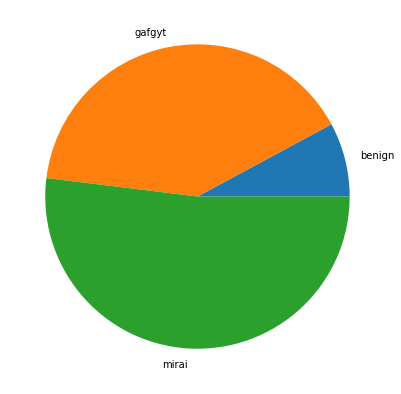

In [508]:
from matplotlib import pyplot as plt
import numpy as np

vals = [555932, 2838272, 3668402]
labels = ['benign', 'gafgyt', 'mirai']
# Создаем диаграмму
fig = plt.figure(figsize =(10, 7))
plt.pie(vals, labels = labels)
 
# Показываем диаграмму
plt.show()

In [516]:
#!spark --session gr0371-sk6
import matplotlib.pyplot as plt
def class_device(benign_df, gafgyt_df, mirai_df, device_name):
    benign_df_count=benign_df.filter(benign_df.device==device_name).count()
    gafgyt_df_count=gafgyt_df.filter(gafgyt_df.device==device_name).count()
    mirai_df_count=mirai_df.filter(mirai_df.device==device_name).count()
    print(device_name, benign_df_count,',', gafgyt_df_count,',', mirai_df_count)
    return
class_device(benign_df, gafgyt_df, mirai_df, 'Danmini_Doorbell')
class_device(benign_df, gafgyt_df, mirai_df, 'Ecobee_Thermostat')
class_device(benign_df, gafgyt_df, mirai_df, 'Ennio_Doorbell')
class_device(benign_df, gafgyt_df, mirai_df, 'Philips_B120N10_Baby_Monitor')
class_device(benign_df, gafgyt_df, mirai_df, 'Provision_PT_737E_Security_Camera')
class_device(benign_df, gafgyt_df, mirai_df, 'Provision_PT_838_Security_Camera')
class_device(benign_df, gafgyt_df, mirai_df, 'Samsung_SNH_1011_N_Webcam')
class_device(benign_df, gafgyt_df, mirai_df, 'SimpleHome_XCS7_1002_WHT_Security_Camera')
class_device(benign_df, gafgyt_df, mirai_df, 'SimpleHome_XCS7_1003_WHT_Security_Camera')

Danmini_Doorbell 49548 , 316650 , 652100
Ecobee_Thermostat 13113 , 310630 , 512133
Ennio_Doorbell 39100 , 316400 , 0
Philips_B120N10_Baby_Monitor 175240 , 312723 , 610714
Provision_PT_737E_Security_Camera 62154 , 330096 , 436010
Provision_PT_838_Security_Camera 98514 , 309040 , 429337
Samsung_SNH_1011_N_Webcam 52150 , 323072 , 0
SimpleHome_XCS7_1002_WHT_Security_Camera 46585 , 303223 , 513248
SimpleHome_XCS7_1003_WHT_Security_Camera 19528 , 316438 , 514860


In [807]:
#!spark --session gr0371-sk6
def under_sample(major_df,major_df_count,major_df2,major_df_count2,minor_df,minor_df_count):
    ratio=int(major_df_count/minor_df_count)
    sampled_maj_df = major_df.sample(False, 1/ratio)
    ratio=int(major_df_count2/minor_df_count)
    sampled_maj_df2 = major_df2.sample(False, 1/ratio)
    return sampled_maj_df,sampled_maj_df2, minor_df

def remove_class_imbalance(benign_df, benign_count, gafgyt_df, gafgyt_count, mirai_df, mirai_count):
    if gafgyt_count < benign_count and   gafgyt_count < mirai_count:
        benign_df, mirai_df, gafgyt_df = under_sample(benign_df, benign_count, mirai_df, mirai_count, gafgyt_df, gafgyt_count)
        return benign_df, mirai_df, gafgyt_df
    elif benign_count< gafgyt_count and  benign_count < mirai_count:
        gafgyt_df, mirai_df, benign_df=under_sample(gafgyt_df, gafgyt_count, mirai_df, mirai_count,benign_df, benign_count)
        return benign_df, mirai_df, gafgyt_df
    elif mirai_count < benign_count and mirai_count < gafgyt_count:
        gafgyt_df, benign_df, mirai_df=under_sample(gafgyt_df, gafgyt_count, benign_df, benign_count, mirai_df,mirai_count)
        return benign_df, mirai_df, gafgyt_df
    
benign_df, mirai_df, gafgyt_df=remove_class_imbalance(benign_df, benign_df_count, gafgyt_df, gafgyt_df_count, mirai_df, mirai_df_count)
benign_df_count=benign_df.count()
gafgyt_df_count=gafgyt_df.count()
mirai_df_count=mirai_df.count()
print(benign_df_count, gafgyt_df_count, mirai_df_count)

555932 567775 613227


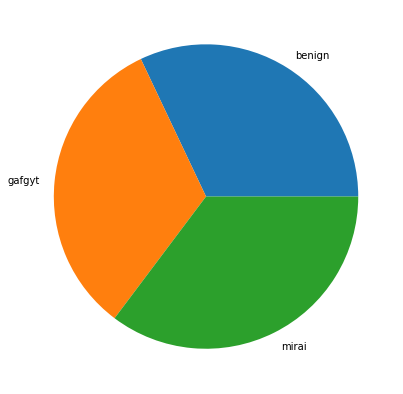

In [545]:
from matplotlib import pyplot as plt
import numpy as np

vals = [555932, 567290, 611631]
labels = ['benign', 'gafgyt', 'mirai']
# Creating plot
fig = plt.figure(figsize =(10, 7))
plt.pie(vals, labels = labels)
 
# show plot
plt.show()

In [808]:
#!spark --session gr0371-sk6
from pyspark.sql.functions import rand
def random_shuffle(df):
    #перетасовка строк
    return df.orderBy(rand())

df=benign_df.union(mirai_df)
df=df.union(gafgyt_df)
df=random_shuffle(df)

In [586]:
#!spark --session gr0371-sk6
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier


cols = df.columns
cols.remove('label')
va = VectorAssembler(
    inputCols=cols,
    outputCol="features"
).transform(df)
train, test = va.randomSplit([0.7, 0.3])

rf = RandomForestClassifier(
    labelCol="label", 
    featuresCol="features",
    maxDepth=2,
    numTrees=3)
model = rf.fit(train)
predictions=model.transform(test)

In [573]:
#!spark --session gr0371-sk6
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
print(('Accuracy is: %s') % accuracy)

Accuracy is: 0.946133871898442


In [589]:
#!spark --session gr0371-sk6
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
print(('Precision is: %s') % precision)

Precision is: 0.9482236347508961


In [591]:
#!spark --session gr0371-sk6
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
print(('Recall is: %s') % recall)

Recall is: 0.9473050210852922


In [598]:
#!spark --session gr0371-sk6
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier


cols = df.columns
cols.remove('label')
va = VectorAssembler(
    inputCols=cols,
    outputCol="features"
).transform(df)
train, test = va.randomSplit([0.7, 0.3])

rf = RandomForestClassifier(
    labelCol="label", 
    featuresCol="features",
    maxDepth=2,
    numTrees=5)
model = rf.fit(train)
predictions=model.transform(test)

In [599]:
#!spark --session gr0371-sk6
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
print(('Accuracy is: %s') % accuracy)

Accuracy is: 0.9683909537901819


In [600]:
#!spark --session gr0371-sk6
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
print(('Precision is: %s') % precision)

Precision is: 0.9703170152852272


In [601]:
#!spark --session gr0371-sk6#!spark --session gr0371-sk6

recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
print(('Recall is: %s') % recall)

Recall is: 0.9683217729656572


In [602]:
#!spark --session gr0371-sk6
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier


cols = df.columns
cols.remove('label')
va = VectorAssembler(
    inputCols=cols,
    outputCol="features"
).transform(df)
train, test = va.randomSplit([0.7, 0.3])

rf = RandomForestClassifier(
    labelCol="label", 
    featuresCol="features",
    maxDepth=2,
    numTrees=10)
model = rf.fit(train)
predictions=model.transform(test)

In [603]:
#!spark --session gr0371-sk6
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
print(('Accuracy is: %s') % accuracy)

Accuracy is: 0.9596399367986437


In [739]:
#!spark --session gr0371-sk6
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
import time

cols = df.columns
cols.remove('label')
va = VectorAssembler(
    inputCols=cols,
    outputCol="features"
).transform(df)
train, test = va.randomSplit([0.7, 0.3])

rf = RandomForestClassifier(
    labelCol="label", 
    featuresCol="features",
    maxDepth=4,
    numTrees=5)
start_time = time.time()
model = rf.fit(train)
exec_time = time.time() - start_time
start_time = time.time()
print ('train time: ', exec_time)
predictions=model.transform(test)
exec_time = time.time() - start_time
print ('test time: ', exec_time)
#4 ядра, 2 исполнителя фул сет

train time:  991.8551964759827
test time:  0.23082685470581055


In [605]:
#!spark --session gr0371-sk6
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
print(('Accuracy is: %s') % accuracy)

Accuracy is: 0.9914646879534444


In [606]:
#!spark --session gr0371-sk6
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
print(('Precision is: %s') % precision)

Precision is: 0.9913015549889204


In [607]:
#!spark --session gr0371-sk6
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
print(('Recall is: %s') % recall)

Recall is: 0.9910830641554916


In [744]:
#!spark --session gr0371-sk6
df50 = df.sample(False, 1/2)

In [746]:
#!spark --session gr0371-sk6
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier


cols = df50.columns
cols.remove('label')
va = VectorAssembler(
    inputCols=cols,
    outputCol="features"
).transform(df50)
train, test = va.randomSplit([0.7, 0.3])

rf = RandomForestClassifier(
    labelCol="label", 
    featuresCol="features",
    maxDepth=4,
    numTrees=5)
start_time = time.time()
model = rf.fit(train)
exec_time = time.time() - start_time
start_time = time.time()
print ('train time: ', exec_time)
predictions=model.transform(test)
exec_time = time.time() - start_time
print ('test time: ', exec_time)
#4 ядра, 2 исполнителя 50% сета

train time:  1007.9103033542633
test time:  0.22549867630004883


In [747]:
#!spark --session gr0371-sk6
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
print(('Accuracy is: %s') % accuracy)
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
print(('Precision is: %s') % precision)
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
print(('Recall is: %s') % recall)

Accuracy is: 0.9796761375839956
Precision is: 0.9806835230997712
Recall is: 0.9798257961331498


In [750]:
#!spark --session gr0371-sk6
conf=sc.getConf()
cores=conf.get("spark.executor.cores")
conf.set('spark.executor.cores', 2)
cores=conf.get("spark.executor.cores")
print(cores)
instances=conf.get("spark.executor.instances")
print(instances)

2
2


In [751]:
#!spark --session gr0371-sk6
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
import time

cols = df.columns
cols.remove('label')
va = VectorAssembler(
    inputCols=cols,
    outputCol="features"
).transform(df)
train, test = va.randomSplit([0.7, 0.3])

rf = RandomForestClassifier(
    labelCol="label", 
    featuresCol="features",
    maxDepth=4,
    numTrees=5)
start_time = time.time()
model = rf.fit(train)
exec_time = time.time() - start_time
start_time = time.time()
print ('train time: ', exec_time)
predictions=model.transform(test)
exec_time = time.time() - start_time
print ('test time: ', exec_time)
#2 ядра, 2 исполнителя фул сет

train time:  856.9662630558014
test time:  0.21073079109191895


In [752]:
#!spark --session gr0371-sk6
conf=sc.getConf()
conf.set('spark.executor.cores', 1)
cores=conf.get("spark.executor.cores")
print(cores)
instances=conf.get("spark.executor.instances")
print(instances)

1
2


In [753]:
#!spark --session gr0371-sk6
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
import time

cols = df.columns
cols.remove('label')
va = VectorAssembler(
    inputCols=cols,
    outputCol="features"
).transform(df)
train, test = va.randomSplit([0.7, 0.3])

rf = RandomForestClassifier(
    labelCol="label", 
    featuresCol="features",
    maxDepth=4,
    numTrees=5)
start_time = time.time()
model = rf.fit(train)
exec_time = time.time() - start_time
start_time = time.time()
print ('train time: ', exec_time)
predictions=model.transform(test)
exec_time = time.time() - start_time
print ('test time: ', exec_time)
#1 ядро, 2 исполнителя фул сет

train time:  835.3313972949982
test time:  0.20510482788085938


In [754]:
#!spark --session gr0371-sk6
conf=sc.getConf()
cores=conf.get("spark.executor.cores")
conf.set('spark.executor.cores', 4)
cores=conf.get("spark.executor.cores")
print(cores)
instances=conf.get("spark.executor.instances")
print(instances)

4
2


In [755]:
#!spark --session gr0371-sk6
df10 = df.sample(False, 1/10)

In [756]:
#!spark --session gr0371-sk6
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier


cols = df10.columns
cols.remove('label')
va = VectorAssembler(
    inputCols=cols,
    outputCol="features"
).transform(df10)
train, test = va.randomSplit([0.7, 0.3])

rf = RandomForestClassifier(
    labelCol="label", 
    featuresCol="features",
    maxDepth=4,
    numTrees=5)
start_time = time.time()
model = rf.fit(train)
exec_time = time.time() - start_time
start_time = time.time()
print ('train time: ', exec_time)
predictions=model.transform(test)
exec_time = time.time() - start_time
print ('test time: ', exec_time)
#4 ядра, 2 исполнителя, 10% сета

train time:  794.6408724784851
test time:  0.2120518684387207


In [757]:
#!spark --session gr0371-sk6
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
print(('Accuracy is: %s') % accuracy)
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
print(('Precision is: %s') % precision)
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
print(('Recall is: %s') % recall)

Accuracy is: 0.9903853549726944
Precision is: 0.9897186853105249
Recall is: 0.989895490501761


In [758]:
#!spark --session gr0371-sk6
df25 = df.sample(False, 1/4)

In [759]:
#!spark --session gr0371-sk6
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier


cols = df25.columns
cols.remove('label')
va = VectorAssembler(
    inputCols=cols,
    outputCol="features"
).transform(df25)
train, test = va.randomSplit([0.7, 0.3])

rf = RandomForestClassifier(
    labelCol="label", 
    featuresCol="features",
    maxDepth=4,
    numTrees=5)
start_time = time.time()
model = rf.fit(train)
exec_time = time.time() - start_time
start_time = time.time()
print ('train time: ', exec_time)
predictions=model.transform(test)
exec_time = time.time() - start_time
print ('test time: ', exec_time)
#4 ядра, 2 исполнителя 25% сета

train time:  814.4897110462189
test time:  0.2268693447113037


In [760]:
#!spark --session gr0371-sk6
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
print(('Accuracy is: %s') % accuracy)
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
print(('Precision is: %s') % precision)
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
print(('Recall is: %s') % recall)

Accuracy is: 0.9907516046656084
Precision is: 0.9903291263807605
Recall is: 0.990528154982681


In [809]:
#!spark --session gr0371-sk6
df75 = df.sample(False, 3/4)

In [762]:
#!spark --session gr0371-sk6
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier


cols = df75.columns
cols.remove('label')
va = VectorAssembler(
    inputCols=cols,
    outputCol="features"
).transform(df75)
train, test = va.randomSplit([0.7, 0.3])

rf = RandomForestClassifier(
    labelCol="label", 
    featuresCol="features",
    maxDepth=4,
    numTrees=5)
start_time = time.time()
model = rf.fit(train)
exec_time = time.time() - start_time
start_time = time.time()
print ('train time: ', exec_time)
predictions=model.transform(test)
exec_time = time.time() - start_time
print ('test time: ', exec_time)
#4 ядра, 2 исполнителя 75% сета

train time:  815.7221870422363
test time:  0.19526124000549316


In [763]:
#!spark --session gr0371-sk6
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
print(('Accuracy is: %s') % accuracy)
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
print(('Precision is: %s') % precision)
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
print(('Recall is: %s') % recall)

Accuracy is: 0.9991884613021484
Precision is: 0.9992294772572617
Recall is: 0.9991581350003454


In [810]:
#!spark --session gr0371-sk6
conf=sc.getConf()
cores=conf.get("spark.executor.cores")
conf.set('spark.executor.cores', 2)
cores=conf.get("spark.executor.cores")
print(cores)
instances=conf.get("spark.executor.instances")
print(instances)

2
2


In [765]:
#!spark --session gr0371-sk6
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier


cols = df10.columns
cols.remove('label')
va = VectorAssembler(
    inputCols=cols,
    outputCol="features"
).transform(df10)
train, test = va.randomSplit([0.7, 0.3])

rf = RandomForestClassifier(
    labelCol="label", 
    featuresCol="features",
    maxDepth=4,
    numTrees=5)
start_time = time.time()
model = rf.fit(train)
exec_time = time.time() - start_time
start_time = time.time()
print ('train time: ', exec_time)
predictions=model.transform(test)
exec_time = time.time() - start_time
print ('test time: ', exec_time)
#2 ядра, 2 исполнителя 10% сета

train time:  796.4584267139435
test time:  0.2350749969482422


In [766]:
#!spark --session gr0371-sk6
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier


cols = df25.columns
cols.remove('label')
va = VectorAssembler(
    inputCols=cols,
    outputCol="features"
).transform(df25)
train, test = va.randomSplit([0.7, 0.3])

rf = RandomForestClassifier(
    labelCol="label", 
    featuresCol="features",
    maxDepth=4,
    numTrees=5)
start_time = time.time()
model = rf.fit(train)
exec_time = time.time() - start_time
start_time = time.time()
print ('train time: ', exec_time)
predictions=model.transform(test)
exec_time = time.time() - start_time
print ('test time: ', exec_time)
#2 ядра, 2 исполнителя 25% сета

train time:  819.0410170555115
test time:  0.22524023056030273


In [767]:
#!spark --session gr0371-sk6
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier


cols = df50.columns
cols.remove('label')
va = VectorAssembler(
    inputCols=cols,
    outputCol="features"
).transform(df50)
train, test = va.randomSplit([0.7, 0.3])

rf = RandomForestClassifier(
    labelCol="label", 
    featuresCol="features",
    maxDepth=4,
    numTrees=5)
start_time = time.time()
model = rf.fit(train)
exec_time = time.time() - start_time
start_time = time.time()
print ('train time: ', exec_time)
predictions=model.transform(test)
exec_time = time.time() - start_time
print ('test time: ', exec_time)
#2 ядра, 2 исполнителя 50% сета

train time:  823.6903290748596
test time:  0.23971009254455566


In [768]:
#!spark --session gr0371-sk6
conf=sc.getConf()
cores=conf.get("spark.executor.cores")
conf.set('spark.executor.cores', 1)
cores=conf.get("spark.executor.cores")
print(cores)
instances=conf.get("spark.executor.instances")
print(instances)

1
2


In [769]:
#!spark --session gr0371-sk6
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier


cols = df50.columns
cols.remove('label')
va = VectorAssembler(
    inputCols=cols,
    outputCol="features"
).transform(df50)
train, test = va.randomSplit([0.7, 0.3])

rf = RandomForestClassifier(
    labelCol="label", 
    featuresCol="features",
    maxDepth=4,
    numTrees=5)
start_time = time.time()
model = rf.fit(train)
exec_time = time.time() - start_time
start_time = time.time()
print ('train time: ', exec_time)
predictions=model.transform(test)
exec_time = time.time() - start_time
print ('test time: ', exec_time)
#1 ядра, 2 исполнителя 50% сета

train time:  850.3790123462677
test time:  0.21196293830871582


In [770]:
#!spark --session gr0371-sk6
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier


cols = df25.columns
cols.remove('label')
va = VectorAssembler(
    inputCols=cols,
    outputCol="features"
).transform(df25)
train, test = va.randomSplit([0.7, 0.3])

rf = RandomForestClassifier(
    labelCol="label", 
    featuresCol="features",
    maxDepth=4,
    numTrees=5)
start_time = time.time()
model = rf.fit(train)
exec_time = time.time() - start_time
start_time = time.time()
print ('train time: ', exec_time)
predictions=model.transform(test)
exec_time = time.time() - start_time
print ('test time: ', exec_time)
#1 ядра, 2 исполнителя 25% сета

train time:  814.3326334953308
test time:  0.2468557357788086


In [771]:
#!spark --session gr0371-sk6
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier


cols = df10.columns
cols.remove('label')
va = VectorAssembler(
    inputCols=cols,
    outputCol="features"
).transform(df10)
train, test = va.randomSplit([0.7, 0.3])

rf = RandomForestClassifier(
    labelCol="label", 
    featuresCol="features",
    maxDepth=4,
    numTrees=5)
start_time = time.time()
model = rf.fit(train)
exec_time = time.time() - start_time
start_time = time.time()
print ('train time: ', exec_time)
predictions=model.transform(test)
exec_time = time.time() - start_time
print ('test time: ', exec_time)
#1 ядра, 2 исполнителя 10% сета

train time:  805.6134021282196
test time:  0.22206807136535645


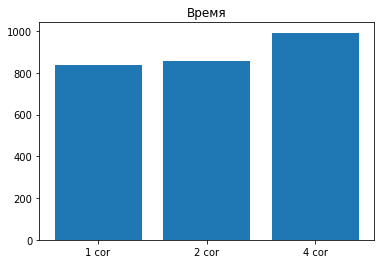

In [798]:
from matplotlib import pyplot as plt
import numpy as np

groups=['1 cor', '2 cor', '4 cor']
counts=[835.3313972949982, 856.9662630558014, 991.8551964759827]
plt.title('Время')
plt.bar(groups, counts)
 
# Показываем диаграмму
plt.show()

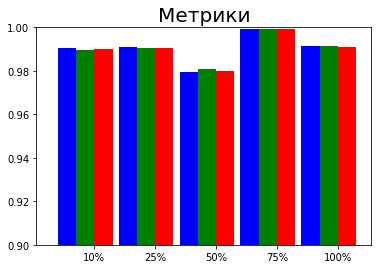

In [790]:
from matplotlib import pyplot as plt
import numpy as np

index = np.arange(5)
values1 = [0.9903853549726944, 0.9907516046656084, 0.9796761375839956, 0.9991884613021484, 0.9914646879534444]
values2 = [0.9897186853105249, 0.9903291263807605, 0.9806835230997712, 0.9992294772572617, 0.9913015549889204]
values3 = [0.989895490501761, 0.990528154982681, 0.9798257961331498, 0.9991581350003454, 0.9910830641554916]
bw = 0.3
plt.axis([-0.5, 5,0.9,1])
plt.title('Метрики', fontsize=20)
plt.bar(index, values1, bw, color='b')
plt.bar(index+bw, values2, bw, color='g')
plt.bar(index+2*bw, values3, bw, color='r')
plt.xticks(index+1.5*bw,['10%', '25%', '50%', '75%', '100%'])
plt.show()

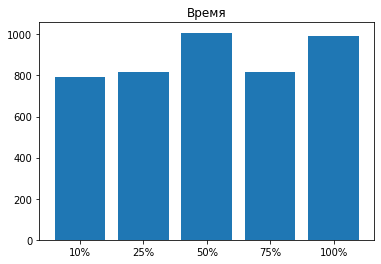

In [791]:
from matplotlib import pyplot as plt
import numpy as np

groups=['10%', '25%', '50%', '75%', '100%']
counts=[794.6408724784851, 815.7221870422363, 1007.9103033542633, 815.7221870422363, 991.8551964759827]
plt.title('Время')
plt.bar(groups, counts)
 
# Показываем диаграмму
plt.show()

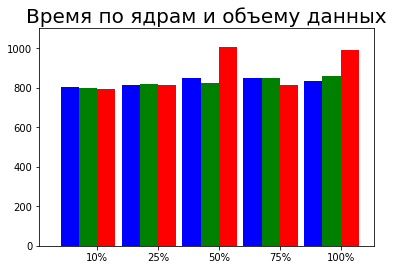

In [816]:
from matplotlib import pyplot as plt
import numpy as np

index = np.arange(5)
values1 = [805.6134021282196, 814.3326334953308, 850.3790123462677, 846.6087341308594, 835.3313972949982]
values2 = [796.4584267139435, 819.0410170555115, 823.6903290748596, 846.8520781993866, 856.9662630558014]
values3 = [794.6408724784851, 814.4897110462189, 1007.9103033542633, 815.7221870422363, 991.8551964759827]
bw = 0.3
plt.axis([-0.5, 5,0,1100])
plt.title('Время по ядрам и объему данных', fontsize=20)
plt.bar(index, values1, bw, color='b')
plt.bar(index+bw, values2, bw, color='g')
plt.bar(index+2*bw, values3, bw, color='r')
plt.xticks(index+1.5*bw,['10%', '25%', '50%', '75%', '100%'])
plt.show()

In [812]:
#!spark --session gr0371-sk6
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
import time

cols = df75.columns
cols.remove('label')
va = VectorAssembler(
    inputCols=cols,
    outputCol="features"
).transform(df75)
train, test = va.randomSplit([0.7, 0.3])

rf = RandomForestClassifier(
    labelCol="label", 
    featuresCol="features",
    maxDepth=4,
    numTrees=5)
start_time = time.time()
model = rf.fit(train)
exec_time = time.time() - start_time
start_time = time.time()
print ('train time: ', exec_time)
predictions=model.transform(test)
exec_time = time.time() - start_time
print ('test time: ', exec_time)
#2 ядра, 2 исполнителя 75% сета

train time:  846.8520781993866
test time:  0.25186896324157715


In [813]:
#!spark --session gr0371-sk6
conf=sc.getConf()
cores=conf.get("spark.executor.cores")
conf.set('spark.executor.cores', 1)
cores=conf.get("spark.executor.cores")
print(cores)
instances=conf.get("spark.executor.instances")
print(instances)

1
2


In [814]:
#!spark --session gr0371-sk6

cols = df75.columns
cols.remove('label')
va = VectorAssembler(
    inputCols=cols,
    outputCol="features"
).transform(df75)
train, test = va.randomSplit([0.7, 0.3])

rf = RandomForestClassifier(
    labelCol="label", 
    featuresCol="features",
    maxDepth=4,
    numTrees=5)
start_time = time.time()
model = rf.fit(train)
exec_time = time.time() - start_time
start_time = time.time()
print ('train time: ', exec_time)
predictions=model.transform(test)
exec_time = time.time() - start_time
print ('test time: ', exec_time)
#1 ядра, 2 исполнителя 75% сета

train time:  846.6087341308594
test time:  0.2531299591064453
